In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D

from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# !pip install tensorflow==2.16.1
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
import os
os.environ['KAGGLE_USERNAME']="mqasimali"
os.environ['KAGGLE_KEY']="03318089e106031ba1a9847ff6f1fd25"
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/brain-tumor-classification-mri

Archive:  /content/brain-tumor-classification-mri.zip
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Define the path to your dataset
dataset_path = '/content/Training'

# Initialize lists to hold file paths and labels
image_paths = []
labels = []

# Load the data from directories
for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(label)

# Create a DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few rows of the dataset
print(data.head())

# Basic statistics
print(data['label'].value_counts())

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

                                    image_path         label
0  /content/Training/glioma_tumor/gg (342).jpg  glioma_tumor
1  /content/Training/glioma_tumor/gg (329).jpg  glioma_tumor
2  /content/Training/glioma_tumor/gg (493).jpg  glioma_tumor
3    /content/Training/glioma_tumor/gg (7).jpg  glioma_tumor
4  /content/Training/glioma_tumor/gg (775).jpg  glioma_tumor
label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
Training set size: 2296
Testing set size: 574


In [ ]:
from tqdm import tqdm
X_train = []
y_train = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 174.25it/s]


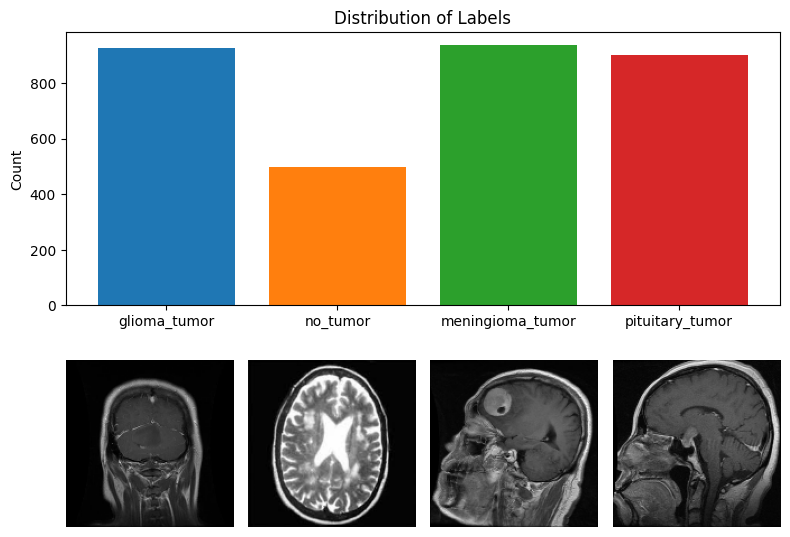

In [ ]:
import matplotlib.pyplot as plt

label_counts = {label: np.sum(y_train == label) for label in labels}
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [ ]:
image_size = (150, 150)
batch_size = 32

# Load and preprocess images
def load_images(df, image_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)


# Undersample the dataset
def oversample_dataset(X, y, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_X = []
    augmented_y = []

    for label in np.unique(y, axis=0):
        label_indices = [i for i, l in enumerate(y) if np.array_equal(l, label)]
        X_label = X[label_indices]
        y_label = y[label_indices]
        count = len(label_indices)

        augmented_X.extend(X_label)
        augmented_y.extend(y_label)

        if count < target_count:
            samples_to_generate = target_count - count
            gen = datagen.flow(X_label, y_label, batch_size=1)
            for _ in range(samples_to_generate):
                img, lbl = next(gen)
                augmented_X.append(img[0])
                augmented_y.append(lbl[0])

    return np.array(augmented_X), np.array(augmented_y)

# Load images
X_train, y_train = load_images(train_data, image_size)
X_test, y_test = load_images(test_data, image_size)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train_categorical = lb.fit_transform(y_train)
y_test_categorical = lb.transform(y_test)

# Determine the target count for each class (maximum class count in training data)
label_counts = Counter(y_train)
target_count = max(label_counts.values())

# Oversample the training and testing datasets
X_train, y_train_categorical = oversample_dataset(X_train, y_train_categorical, target_count)
X_test, y_test_categorical = oversample_dataset(X_test, y_test_categorical, target_count)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test_categorical.shape}")


Training data shape: (2672, 150, 150, 3)
Training labels shape: (2672, 4)
Testing data shape: (2672, 150, 150, 3)
Testing labels shape: (2672, 4)


In [ ]:


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1536, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
history = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=batch_size),
                    validation_data=(X_test, y_test_categorical),
                    epochs=50)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 153s 850ms/step - accuracy: 0.6038 - loss: 1.2168 - val_accuracy: 0.3728 - val_loss: 8.1912
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.8503 - loss: 0.4361 - val_accuracy: 0.6632 - val_loss: 1.0479
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.8326 - loss: 0.4741 - val_accuracy: 0.3125 - val_loss: 57.4073
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.9075 - loss: 0.2929 - val_accuracy: 0.8510 - val_loss: 0.5630
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 250ms/step - accuracy: 0.9193 - loss: 0.2336 - val_accuracy: 0.8099 - val_loss: 0.6358
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.9152 - loss: 0.2425 - val_accuracy: 0.7638 - val_loss: 0.7311
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.9256 - loss: 0.2556 - val_accuracy: 0.8739 - val_loss: 0.3666
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.9211 - loss: 0.2387 - val_accuracy: 0.8

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test accuracy: {accuracy * 100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9566 - loss: 0.1480
Test accuracy: 93.90%


In [ ]:
model.save("brain-tumor.h5")